In [188]:
## TODO: (APPLIES TO BOTH grid_level and tier_level) 
##       when loading saved pycaret model, MinMaxScaler is excluded
##       from Pipeline object. Determine cause and fix, or manually
##       add MinMaxScaler
## 
##       train best performing models on entire dataset and overwrite
##       existing model files

In [149]:
import os
import awswrangler as wr
import pandas as pd
import numpy as np
import tempfile
import joblib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.metrics import mean_absolute_error, classification_report

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: "{:.5f}".format(x))

In [3]:
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'
seed = 42

In [151]:
# AWS directories
s3_root = 's3://crc-data-lake-research/sma/jimmy_woo/'
database = 'crc_data_lake_research'
results_path = '{}temp_resuts'.format(s3_root)

In [5]:
query = """
SELECT tier_4, grid_id, service_provider, band, block, market_share, num_data_pts
FROM crc_data_lake_research.sma_market_share_grid
"""

market_df = wr.athena.read_sql_query(
    query,
    database=database,
    s3_output=results_path,
    keep_files=False
)

In [12]:
query = """
SELECT tier_4, grid_id, population_2016 as population
FROM crc_data_lake_structured.ised_grid
"""

pop_df =  wr.athena.read_sql_query(
    query,
    database=database,
    s3_output=results_path,
    keep_files=False
)

In [7]:
query = """
SELECT tier_4, grid_id, service, block, tx_density
FROM crc_data_lake_research.sma_ryan_fabek_tutela_tower_density_per_grid_cell
"""

tower_df =  wr.athena.read_sql_query(
    query,
    database=database,
    s3_output=results_path,
    keep_files=False
)

tower_df.rename(columns={'service': 'band'}, inplace=True)

In [13]:
# join all data frames
df = market_df.merge(pop_df, how='left', on=['tier_4', 'grid_id'])
df = df.merge(tower_df, how='left', on=['tier_4', 'band', 'block', 'grid_id'])
df['tx_density'] = df['tx_density'].fillna(0)

labels
mean: 582 median: 18 max: 494392


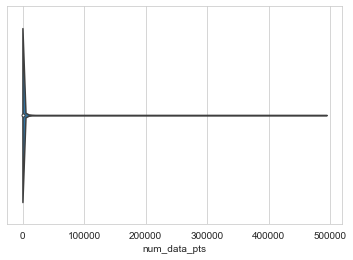

In [11]:
sns.set_style('whitegrid')

plot_df = df[['num_data_pts']]
plot_df.loc[:, 'num_data_pts'] = plot_df['num_data_pts'].astype(int)
y = plot_df['num_data_pts'].to_numpy()

# distribution of number of data points
sns.violinplot(x=plot_df['num_data_pts']);

print('labels\nmean: {:.0f} median: {:.0f} max: {}'.format(np.mean(y), np.median(y), np.max(y)))

In [12]:
from pycaret.regression import *

In [73]:
# split data for holdout test
df_train, df_test = train_test_split(df, test_size=0.15, random_state=seed)
encoder = ce.TargetEncoder(cols=['tier_4', 'grid_id', 'service_provider', 'band', 'block'], return_df=True)
custom_pp = [("target_encoder", encoder)]

s = setup(df_train, 
          target='num_data_pts',
          train_size=0.7/0.85,
          normalize=True,
          normalize_method='minmax', 
          preprocess=False,
          custom_pipeline=custom_pp,
          fold=5,
          fold_shuffle=True)

In [74]:
model = compare_models()

In [75]:
# evaluate on test set
pred = predict_model(model, data=df_test)

In [19]:
# save trained model
with tempfile.TemporaryFile() as fp:
    joblib.dump(model, fp)
    fp.seek(0)
    wr.s3.upload(local_file=fp, path=s3_root + 'saved_models/grid_regression.pkl')

In [18]:
from pycaret.classification import *

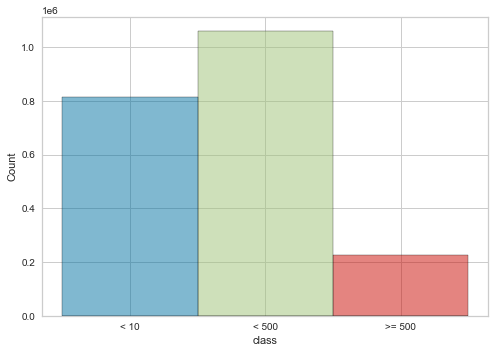

In [170]:
df_c = df.copy(deep=True)

# assign classes
df_c['class'] = ''
df_c.loc[df_c['num_data_pts'] < 10, 'class'] = '0'
df_c.loc[(df_c['num_data_pts'] >= 10) & (df_c['num_data_pts'] < 500), 'class'] = '1'
#df_c.loc[(df_c['num_data_pts'] >= 100) & (df_c['num_data_pts'] < 500), 'class'] = '2'
df_c.loc[df_c['num_data_pts'] >= 500, 'class'] = '2'

# observe at class distribution
f = sns.histplot(data=df_c.sort_values(by='class'), x='class', hue='class', legend=False);
f.xaxis.set_ticks([0, 1, 2])
f.set_xticklabels(['< 10', '< 500', '>= 500']);
plt.show()

df_c['class'] = pd.to_numeric(df_c['class'])
df_c = df_c.drop(columns=['num_data_pts'])

In [66]:
# split data for holdout test
df_train, df_test = train_test_split(df_c, test_size=0.15, random_state=seed)
encoder = ce.TargetEncoder(cols=['tier_4', 'grid_id', 'service_provider', 'band', 'block'], return_df=True)
custom_pp = [("target_encoder", encoder)]

s = setup(df_train, 
          target='class',
          train_size=0.7/0.85,
          normalize=True,
          normalize_method='minmax', 
          preprocess=False,
          custom_pipeline=custom_pp,
          fold=5,
          fold_shuffle=True)

In [67]:
model = compare_models()

In [68]:
# evaluate on test set
pred = predict_model(model, data=df_test)

In [69]:
print(classification_report(df_test['class'].astype('int'), pred['Label']))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91    121565
           1       0.93      0.89      0.91    159431
           2       0.92      0.90      0.91     33757

    accuracy                           0.91    314753
   macro avg       0.91      0.91      0.91    314753
weighted avg       0.91      0.91      0.91    314753



In [23]:
# save trained model
with tempfile.TemporaryFile() as fp:
    joblib.dump(model, fp)
    fp.seek(0)
    wr.s3.upload(local_file=fp, path=s3_root + 'saved_models/grid_classification.pkl')

In [187]:
## example code for model evaluation

# load model
#model = load_model('grid_classification', platform='aws', authentication={'bucket': 'crc-data-lake-research', 'path': 'sma/jimmy_woo/saved_models/'})

def grid_predict(tier, grid_id, service_provider, band, block):
    # extract constant parameters from joined dataframe
    row = df[(df['tier_4'] == tier) & (df['grid_id'] == grid_id) & (df['service_provider'] == service_provider) &
             (df['band'] == band) & (df['block'] == block)][['population', 'market_share', 'tx_density']].T.values

    population, market_share, tx_density = row
    
    # construct observation
    obs = pd.DataFrame.from_dict({'tier_4': tier,
                              'grid_id': grid_id,
                              'service_provider': service_provider,
                              'band': band,
                              'block': block,
                              'population': population[0],
                              'market_share': market_share[0],
                              'tx_density': tx_density[0]}, orient='index').T
    
    # apply transformations here
    obs = model['target_encoder'].transform(obs).astype('float')
    
    return model['trained_model'].predict(obs)